# I. Set Up

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import fnmatch
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

2023-04-26 00:09:48.376925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dropdown(description='Set :', options=('Full', 'All', 'New', 'Bona'), value='Full')

# II. Load Data

In [3]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*nE16*nt24*ndt16*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget


Dropdown(description='TSNE File :', options=('hist3D-Full-nE16-nt24-ndt16-normnone.pkl', 'hist3D-Full-nE16-nt2…

In [4]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
# features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

Number of Features:  95473
Number of Property Sets:  95473


# III. TSNE

TSNE Model

In [51]:
# PCA and TSNE Setting
n_pca = 22
n_comp = 2
# perp = 125#200# 90 #80
# learn_rate = 250
perp = 50#200# 90 #80
learn_rate = 120
early_exag = 1
iterations = 2500
random_state = 11
init = 'random' #'random'

# Define TSNE Model
tsne_model = TSNE(n_components = n_comp , perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init=init, random_state=random_state) # rosanne 78592 #lin 27514
# PCA
pca_model = PCA(n_pca)
X_new = pca_model.fit_transform(features) 
# Run TSNE Model on Data
tsne_out = tsne_model.fit_transform(X_new)
# tsne_out = tsne_model.fit_transform(features)
print(tsne_out.shape)


# Save TSNE Output
df_tsne = pd.DataFrame(tsne_out, columns=['tsne1', 'tsne2'])
df_tsne['obsreg_id'] = list(ids)
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
df_tsne.to_csv(f'{global_path}/{set_id}/tsne-{set_id}-{data_rep}-{n_comp}D-perp{perp}-lr{learn_rate}-ee{early_exag}-it{iterations}-PCA{n_pca}-init{init}-rs{random_state}.csv', index=False)


(95473, 2)


TSNE Convergence

In [59]:
# PCA and TSNE Setting
n_pca = 22#15 #9#15#16#25 # 20#16 #20
n_comp = 2
perp = 50#200# 90 #80
learn_rate = 120
early_exag = 1
# iterations = 2000
random_state = 11# 27514 # 111 #  27514
init = 'random' #'random'
# PCA
pca_model = PCA(n_pca)
X_new = pca_model.fit_transform(features)
# Run TSNE Model on Data
n_iter_list = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000, 6000,7500,10000]#,5500,6000,6500,7000,7500]
# n_iter_list = [6000,7500,10000]#,5500,6000,6500,7000,7500]
# n_iter_list = [4500,5000,5500,6000,6500,7000,7500,8000]
# n_iter_list = [8500,9000,9500,10000]
div_list = []
count = 0
total_count = len(n_iter_list)
for n_iter in n_iter_list:
    iterations = n_iter 
    tsne = TSNE(n_components=n_comp , perplexity=perp, learning_rate=learn_rate , n_iter=iterations, random_state=random_state,early_exaggeration=early_exag,init = init)
    tsne_out = tsne.fit_transform(X_new)
    df_tsne = pd.DataFrame(tsne_out, columns=['tsne1', 'tsne2'])
    df_tsne['obsreg_id'] = list(ids)
    input_file = input_widget.value
    data_rep = input_file.split(".pkl")[0]
    df_tsne.to_csv(f'{global_path}/{set_id}/tsne-{set_id}-{data_rep}-{n_comp}D-perp{perp}-lr{learn_rate}-ee{early_exag}-it{iterations}-init{init}-PCA{n_pca}-rs{random_state}.csv', index=False)
    div_list.append(tsne.kl_divergence_)
    print(iterations, tsne.kl_divergence_)
    count = count + 1
    print(f'Counter: {count} of {total_count}')
print(f'DONE!!!')

df_div = pd.DataFrame({'iter': n_iter_list, 'div': div_list})
df_div.to_csv(f'{global_path}/{set_id}/divtsne-{set_id}-{data_rep}-{n_comp}D-perp{perp}-lr{learn_rate}-ee{early_exag}-init{init}-PCA{n_pca}-rs{random_state}-n_iter{n_iter_list[0]}-{n_iter_list[-1]}.csv', index=False)

500 5.077170372009277
Counter: 1 of 13
1000 4.6331987380981445
Counter: 2 of 13
1500 4.475147247314453
Counter: 3 of 13
2000 4.3859968185424805
Counter: 4 of 13
2500 4.325563430786133
Counter: 5 of 13
3000 4.281031608581543
Counter: 6 of 13
3500 4.246659755706787
Counter: 7 of 13
4000 4.219965934753418
Counter: 8 of 13
4500 4.199372291564941
Counter: 9 of 13
5000 4.184804916381836
Counter: 10 of 13
6000 4.173335075378418
Counter: 11 of 13
7500 4.159151077270508
Counter: 12 of 13
10000 4.146641731262207
Counter: 13 of 13
DONE!!!


In [36]:
df_div =  pd.DataFrame({'iter': n_iter_list, 'div': div_list})
df_div.to_csv(f'{global_path}/{set_id}/divtsne-{set_id}-{data_rep}-{n_comp}D-perp{perp}-lr{learn_rate}-ee{early_exag}-init{init}-PCA{n_pca}-rs{random_state}-n_iter{n_iter_list[0]}-{n_iter_list[-1]}.csv', index=False)

NameError: name 'n_iter_list' is not defined

Plot TSNE

In [66]:
files = os.listdir(f'{global_path}/{set_id}/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*hist3D*nE16*perp50*lr120*it3500*PCA22*11*csv')]
# tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*nE16*perp80*lr100*PCA20*csv')]
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget

Dropdown(description='TSNE File :', options=('tsne-Full-hist3D-Full-nE16-nt24-ndt16-normnone-2D-perp50-lr120-e…

In [67]:
# Load the DataFrame from the CSV file
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')

# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10','9072_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']
ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']

# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
xue = ['957_208', '3389_274','15211_38','15214_29']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59']
vasquez = ['2025_39','9548_14','15113_59']
goulding_nandra = ['9875_166', '9456_274', '5849_62', '8636_2', '8636_3'] # last one not listed 2012 2015

tsne_lin = df_tsne.loc[df_tsne['obsreg_id'].isin(lin)]
tsne_irwin = df_tsne.loc[df_tsne['obsreg_id'].isin(irwin)]
tsne_glennie = df_tsne.loc[df_tsne['obsreg_id'].isin(glennie)]
tsne_jonker = df_tsne.loc[df_tsne['obsreg_id'].isin(jonker)]
tsne_vasquez= df_tsne.loc[df_tsne['obsreg_id'].isin(vasquez)]
tsne_xue = df_tsne.loc[df_tsne['obsreg_id'].isin(xue)]
tsne_goulding = df_tsne.loc[df_tsne['obsreg_id'].isin(goulding_nandra)]

tsne_m101ulx = df_tsne.loc[df_tsne['obsreg_id'].isin(m101ulx)]
tsne_distefano = df_tsne.loc[df_tsne['obsreg_id'].isin(distefano)]
tsne_moredips = df_tsne.loc[df_tsne['obsreg_id'].isin(ieva)]
tsne_parmar = df_tsne.loc[df_tsne['obsreg_id'].isin(parmar)] # LMXB

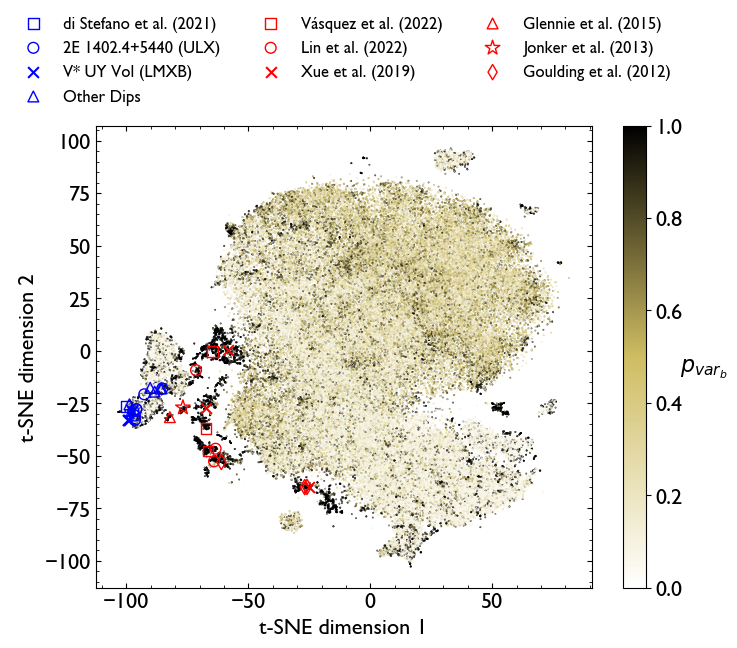

In [70]:
# Plot 3D
import matplotlib.colors as mcolors
# Define Font Settings
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
fig, axs = plt.subplots(figsize=(8, 6))
# Define the two colors for the colormap
imperial = '#003E74'
imperial2 = '#002147'
imperial3 = "#00ACD7"
darkblue = '#003170'
harvard = '#A51C30'
harvard2 = '#ed1b34'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
gold2 = '#dfc16d'
# Create a dictionary that maps values between 0 and 1 to colors
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
# Create the colormap using the dictionary and the two colors
cmap_ic = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white', imperial,'black'], N=256)
cmap_h = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white', harvard,'black'], N=256)
cmap_gold = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',gold,'black'], N=256)
# fig.suptitle(tsne_file)
colourmap_var = 'viridis_r'
colourmap_var = 'magma_r'
colourmap_var = 'binary'
colourmap_var = cmap_ic 
colourmap_var = cmap_gold 

var_b = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_properties['var_prob_b'], s=0.1, cmap=colourmap_var)
axs.set_xlabel('t-SNE dimension 1')
axs.set_ylabel('t-SNE dimension 2')
# axs.set_title(r'$p_{var_b}$')

markersize = 40
c_f = 'red'
c_d = 'blue'

axs.scatter(tsne_distefano['tsne1'], tsne_distefano['tsne2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(tsne_m101ulx['tsne1'], tsne_m101ulx['tsne2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(tsne_parmar['tsne1'], tsne_parmar['tsne2'], c=c_d, marker='x', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(tsne_moredips['tsne1'], tsne_moredips['tsne2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='Other Dips')
 
axs.scatter(tsne_vasquez['tsne1'], tsne_vasquez['tsne2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Vásquez et al. (2022)')
axs.scatter(tsne_lin['tsne1'], tsne_lin['tsne2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Lin et al. (2022)')
axs.scatter(tsne_xue['tsne1'], tsne_xue['tsne2'], c=c_f, marker='x', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
# axs.scatter(tsne_irwin['tsne1'], tsne_irwin['tsne2'], c='green', marker='*', s=100, label='Irwin et al. (2016) - Flares')
axs.scatter(tsne_glennie['tsne1'], tsne_glennie['tsne2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(tsne_jonker['tsne1'], tsne_jonker['tsne2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')
axs.scatter(tsne_goulding['tsne1'], tsne_goulding['tsne2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Goulding et al. (2012)')


axs.grid(False) 
cbar = axs.figure.colorbar(var_b, ax=axs)
cbar.ax.set_ylabel(r'$p_{var_b}$', rotation = 0,labelpad=15)
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.27),
          ncol=3, frameon = False,fontsize=12)
# axs.legend(loc='upper right', bbox_to_anchor=(1., 1),frameon = False,fontsize=12)
# plt.tight_layout()


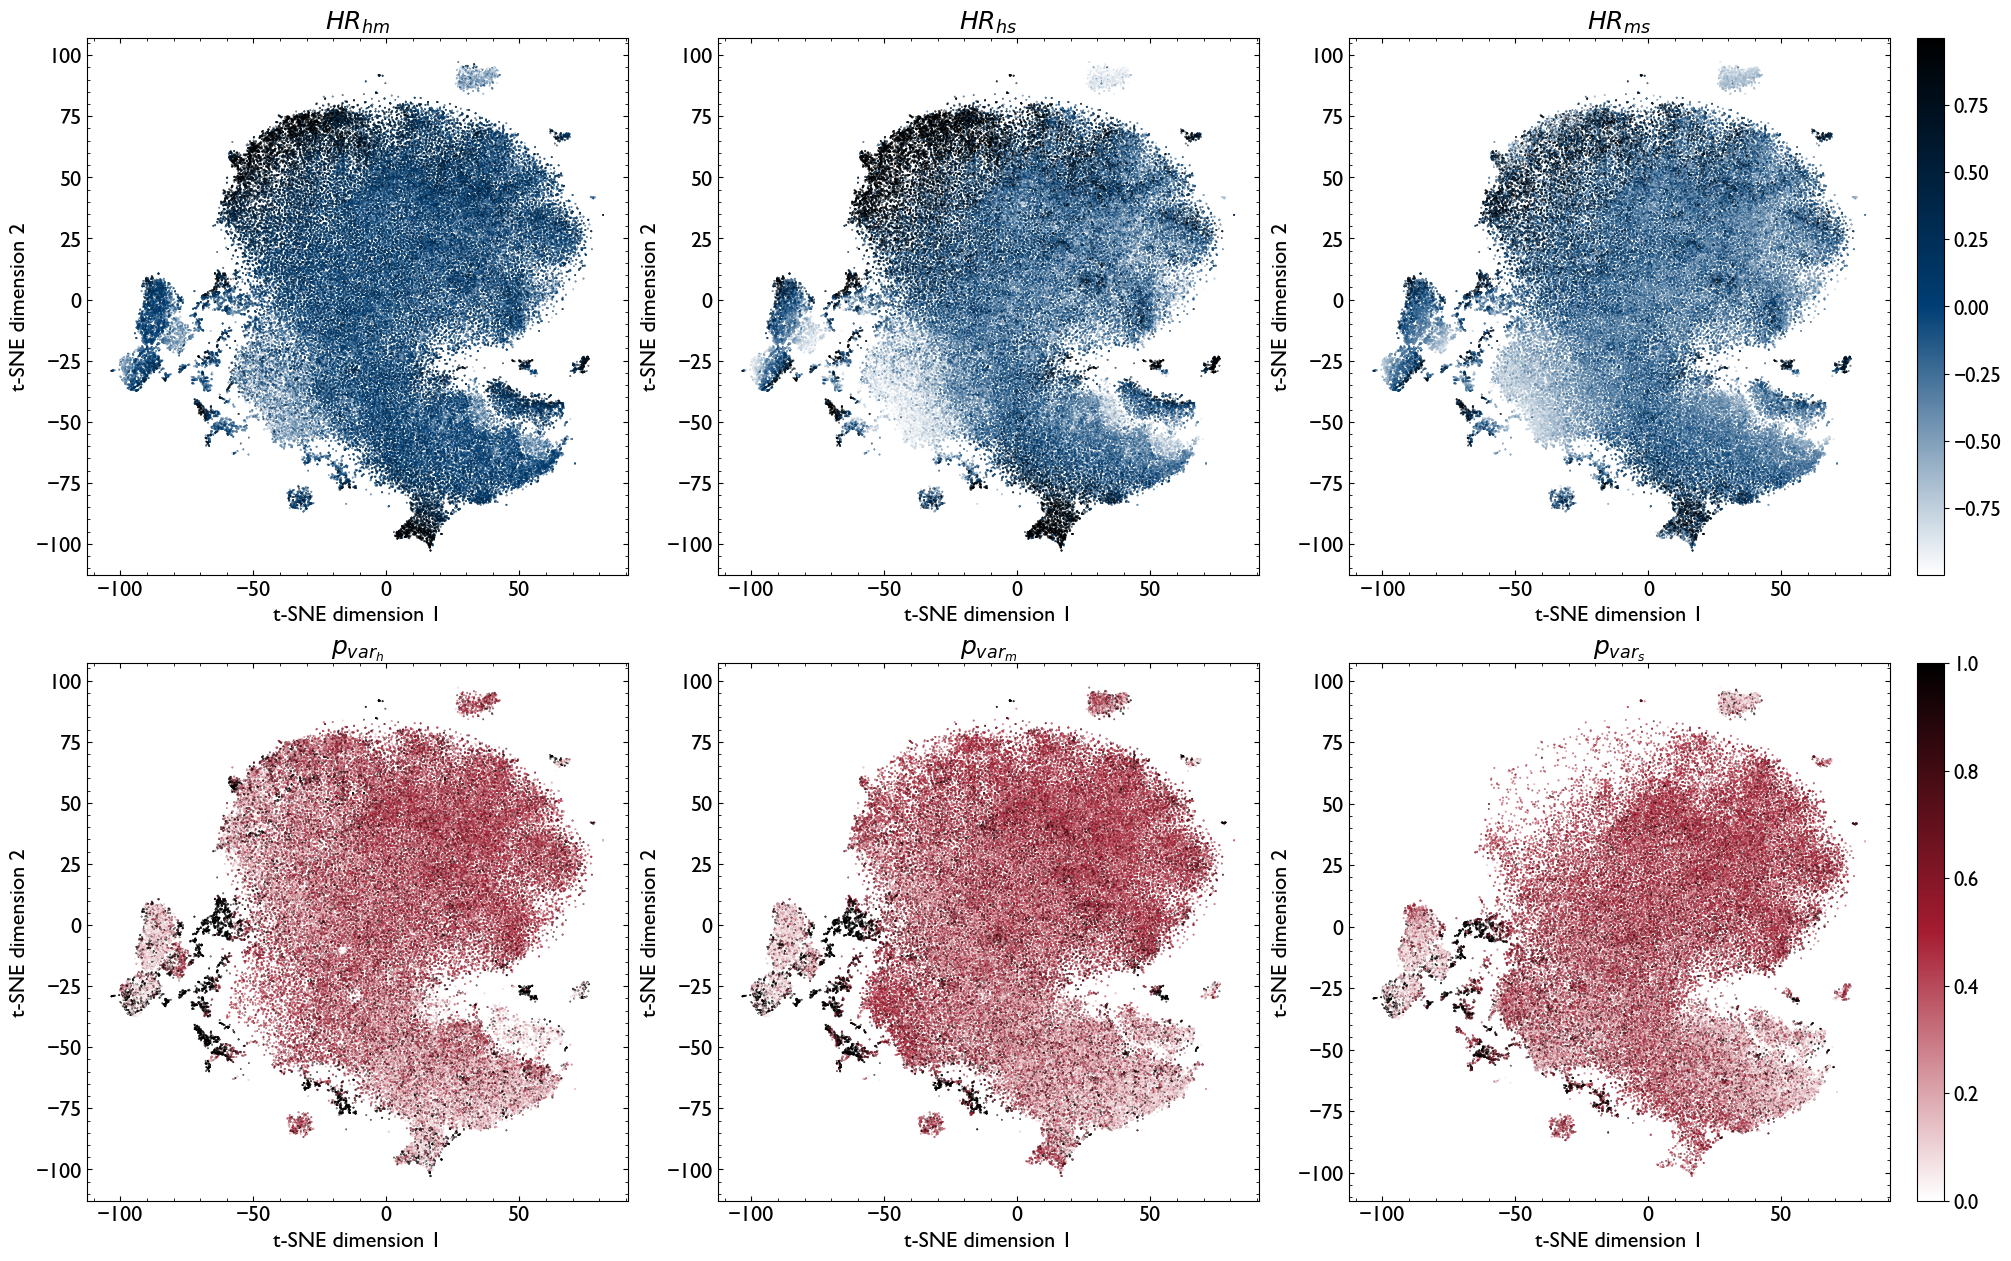

In [71]:
# Plot 3D
fig, axs = plt.subplots(2, 3, figsize=(20, 12.5),constrained_layout = True)
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
# Define the two colors for the colormap
imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
gold2 = '#dfc16d'
# Create a dictionary that maps values between 0 and 1 to colors
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
# Create the colormap using the dictionary and the two colors
cmap_ic = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white', imperial,'black'], N=256)
cmap_h = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white', harvard,'black'], N=256)
cmap_gold = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',gold,'black'], N=256)

colourmap_hard = cmap_ic
colourmap_var = cmap_h


hard_hm = axs[0,0].scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_properties['hard_hm'], s=0.1, cmap=colourmap_hard)
axs[0,0].set_xlabel('t-SNE dimension 1')
axs[0,0].set_ylabel('t-SNE dimension 2')
axs[0,0].set_title(r'$HR_{hm}$')
axs[0,0].minorticks_on()
axs[0,0].tick_params(which='both', direction='in', top=True, right=True)
# cbar_hm = fig.colorbar(hard_hm, ax = axs[0,0])

hard_hs = axs[0,1].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['hard_hs'], s=0.1, cmap=colourmap_hard)
axs[0,1].set_xlabel('t-SNE dimension 1')
axs[0,1].set_ylabel('t-SNE dimension 2')
axs[0,1].set_title(r'$HR_{hs}$')
axs[0,1].minorticks_on()
axs[0,1].tick_params(which='both', direction='in', top=True, right=True)
# cbar_hs = fig.colorbar(hard_hs, ax = axs[0,1])

hard_ms = axs[0,2].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['hard_ms'], s=0.1, cmap=colourmap_hard)
axs[0,2].set_xlabel('t-SNE dimension 1')
axs[0,2].set_ylabel('t-SNE dimension 2')
axs[0,2].set_title(r'$HR_{ms}$')
axs[0,2].minorticks_on()
axs[0,2].tick_params(which='both', direction='in', top=True, right=True)
cbar_ms = fig.colorbar(hard_ms, ax = axs[0,2])

var_h = axs[1,0].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_h'], s=0.1, cmap=colourmap_var)
axs[1,0].set_xlabel('t-SNE dimension 1')
axs[1,0].set_ylabel('t-SNE dimension 2')
axs[1,0].set_title(r'$p_{var_h}$')
axs[1,0].minorticks_on()
axs[1,0].tick_params(which='both', direction='in', top=True, right=True)
# cbar_h = fig.colorbar(var_h, ax = axs[1,0])

var_m = axs[1,1].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_m'], s=0.1, cmap=colourmap_var)
axs[1,1].set_xlabel('t-SNE dimension 1')
axs[1,1].set_ylabel('t-SNE dimension 2')
axs[1,1].set_title(r'$p_{var_m}$')
axs[1,1].minorticks_on()
axs[1,1].tick_params(which='both', direction='in', top=True, right=True)
# cbar_m = fig.colorbar(var_m, ax = axs[1,1])
# cbar_m.ax.set_xlabel(r'$p_{var_b}$', rotation = 0,labelpad=-50)

var_s = axs[1,2].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_s'], s=0.1, cmap=colourmap_var)
axs[1,2].set_xlabel('t-SNE dimension 1')
axs[1,2].set_ylabel('t-SNE dimension 2')
axs[1,2].set_title(r'$p_{var_s}$')
axs[1,2].minorticks_on()
axs[1,2].tick_params(which='both', direction='in', top=True, right=True)
cbar_s = fig.colorbar(var_s, ax = axs[1,2])


# for axs in axs.flatten()[0:1]:
#     axs.scatter(tsne_vasquez['tsne1'], tsne_vasquez['tsne2'], c='red', marker='x', s=100, label='Quirola-Vásquez et al. (2022) - Flares')
#     axs.scatter(tsne_lin['tsne1'], tsne_lin['tsne2'], c='red', marker='o', s=10, label='Lin et al. (2022) - Flares')
#     axs.scatter(tsne_xue['tsne1'], tsne_xue['tsne2'], c='magenta', marker='s', s=10, label='Xue et al. (2019) - Flares')
#     axs.scatter(tsne_irwin['tsne1'], tsne_irwin['tsne2'], c='green', marker='*', s=100, label='Irwin et al. (2016) - Flares')
#     axs.scatter(tsne_glennie['tsne1'], tsne_glennie['tsne2'], c='red', marker='v', s=100, label='Glennie et al. (2015) - Flares')
#     axs.scatter(tsne_jonker['tsne1'], tsne_jonker['tsne2'], c='magenta', marker='x', s=100, label='Jonker et al. (2013) - Flares')
#     axs.scatter(tsne_m101ulx['tsne1'], tsne_m101ulx['tsne2'], c='blue', marker='x', s=100, label='m101ulx')
#     axs.scatter(tsne_distefano['tsne1'], tsne_distefano['tsne2'], c='cyan', marker='x', s=100, label='di Stefano et al. (2021)')
#     axs.scatter(tsne_parmar['tsne1'], tsne_parmar['tsne2'], c='purple', marker='x', s=100, label='Parmar LMXB dips')
#     axs.legend()

plt.show()

# IV. UMAP

UMAP Model

In [ ]:
# pca Setting
n_comp = 2
neighbours = 50
min_d = 0.1
learn_rate = 0.1
sp = 2

# Define pca Model
umap_model = umap.UMAP(n_components = n_comp, n_neighbors = neighbours, min_dist = min_d, learning_rate = learn_rate, random_state=42, spread = sp)
# Run pca Model on Data
umap_out = umap_model.fit_transform(features)
print(umap_out.shape)

# Save pca Output
df_umap = pd.DataFrame(umap_out, columns=['umap1', 'umap2'])
df_umap['obsreg_id'] = list(ids)
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
df_umap.to_csv(f'{global_path}/{set_id}/umap-{set_id}-{data_rep}-{n_comp}D-neighb{neighbours}-mind-{min_d}-lr{learn_rate}-sp{sp}.csv', index=False)



Plot UMAP

In [ ]:
files = os.listdir(f'{global_path}/{set_id}/')
umap_files = [f for f in files if fnmatch.fnmatch(f, 'umap*')]
umap_widget = widgets.Dropdown(options=umap_files[:],value=umap_files[0],description='UMAP File :',disabled=False); umap_widget

In [ ]:
# Load the DataFrame from the CSV file
umap_file = umap_widget.value
df_umap = pd.read_csv(f'{global_path}/{set_id}/{umap_file}')
# Use loc to select rows that match the IDs in list2, and store the result in a new DataFrame
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
rosanne = ['13814_567']
umap_flares = df_umap.loc[df_umap['obsreg_id'].isin(flares)]
umap_dips = df_umap.loc[df_umap['obsreg_id'].isin(dips)]
umap_rosanne = df_umap.loc[df_umap['obsreg_id'].isin(rosanne)]

In [ ]:
# Plot
fig, axs = plt.subplots(2, 3, figsize=(20, 12),constrained_layout = True)
fig.suptitle(umap_file)
colourmap_hard = 'viridis_r' #inferno 'viridis_r' 'plasma_r'
colourmap_var = 'plasma_r'

hard_hm = axs[0,0].scatter(df_umap['umap1'], df_umap['umap2'],c=df_properties['hard_hm'], s=0.1, cmap=colourmap_hard)
axs[0,0].set_xlabel('UMAP feature 1')
axs[0,0].set_ylabel('UMAP feature 2')
axs[0,0].set_title(f'hard_hm')
fig.colorbar(hard_hm, ax = axs[0,0])

hard_hs = axs[0,1].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['hard_hs'], s=0.1, cmap=colourmap_hard)
axs[0,1].set_xlabel('UMAP feature 1')
axs[0,1].set_ylabel('UMAP feature 2')
axs[0,1].set_title(f'hard_hs')
fig.colorbar(hard_hs, ax = axs[0,1])

hard_ms = axs[0,2].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['hard_ms'], s=0.1, cmap=colourmap_hard)
axs[0,2].set_xlabel('UMAP feature 1')
axs[0,2].set_ylabel('UMAP feature 2')
axs[0,2].set_title(f'hard_ms')
fig.colorbar(hard_ms, ax = axs[0,2])

var_h = axs[1,0].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['var_prob_h'], s=0.1, cmap=colourmap_var)
axs[1,0].set_xlabel('UMAP feature 1')
axs[1,0].set_ylabel('UMAP feature 2')
axs[1,0].set_title(f'var_prob_h')
fig.colorbar(var_h, ax = axs[1,0])

var_m = axs[1,1].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['var_prob_m'], s=0.1, cmap=colourmap_var)
axs[1,1].set_xlabel('UMAP feature 1')
axs[1,1].set_ylabel('UMAP feature 2')
axs[1,1].set_title(f'var_prob_m')
fig.colorbar(var_m, ax = axs[1,1])

var_s = axs[1,2].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['var_prob_s'], s=0.1, cmap=colourmap_var)
axs[1,2].set_xlabel('UMAP feature 1')
axs[1,2].set_ylabel('UMAP feature 2')
axs[1,2].set_title(f'var_prob_s')
fig.colorbar(var_s, ax = axs[1,2])

for ax in axs.flatten()[0:1]:
    ax.scatter(umap_flares['umap1'], umap_flares['umap2'], c='red', marker='x', s=100, label='Flares')
    ax.scatter(umap_dips['umap1'], umap_dips['umap2'], c='blue', marker='x', s=100, label='Dips')
    ax.scatter(umap_rosanne['umap1'], umap_rosanne['umap2'], c='black', marker='x', s=100, label='Rosanne')
    ax.legend()

plt.show()

# V. PCA

In [ ]:
# Run PCA
pca_model = PCA(n_components=2)
pca_out = pca_model.fit_transform(features) 

# Save UMAP Output
df_pca = pd.DataFrame(pca_out, columns=['pca1', 'pca2'])
df_pca['obsreg_id'] = list(ids)
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
df_pca.to_csv(f'{global_path}/{set_id}/pca-{set_id}-{data_rep}.csv', index=False)

In [ ]:
files = os.listdir(f'{global_path}/{set_id}/')
pca_files = [f for f in files if fnmatch.fnmatch(f, 'pca*')]
pca_widget = widgets.Dropdown(options=pca_files[:],value=pca_files[0],description='PCA File :',disabled=False); pca_widget

In [ ]:
# Load the DataFrame from the CSV file
pca_file = pca_widget.value
df_pca = pd.read_csv(f'{global_path}/{set_id}/{pca_file}')
# Use loc to select rows that match the IDs in list2, and store the result in a new DataFrame
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
rosanne = ['13814_567']
pca_flares = df_pca.loc[df_pca['obsreg_id'].isin(flares)]
pca_dips = df_pca.loc[df_pca['obsreg_id'].isin(dips)]
pca_rosanne = df_pca.loc[df_pca['obsreg_id'].isin(rosanne)]

In [ ]:
# Plot
fig, axs = plt.subplots(2, 3, figsize=(20, 12),constrained_layout = True)
fig.suptitle(pca_file)
colourmap_hard = 'viridis_r' #inferno 'viridis_r' 'plasma_r'
colourmap_var = 'plasma_r'

hard_hm = axs[0,0].scatter(df_pca['pca1'], df_pca['pca2'],c=df_properties['hard_hm'], s=0.1, cmap=colourmap_hard)
axs[0,0].set_xlabel('pca feature 1')
axs[0,0].set_ylabel('pca feature 2')
axs[0,0].set_title(f'hard_hm')
fig.colorbar(hard_hm, ax = axs[0,0])

hard_hs = axs[0,1].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['hard_hs'], s=0.1, cmap=colourmap_hard)
axs[0,1].set_xlabel('pca feature 1')
axs[0,1].set_ylabel('pca feature 2')
axs[0,1].set_title(f'hard_hs')
fig.colorbar(hard_hs, ax = axs[0,1])

hard_ms = axs[0,2].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['hard_ms'], s=0.1, cmap=colourmap_hard)
axs[0,2].set_xlabel('pca feature 1')
axs[0,2].set_ylabel('pca feature 2')
axs[0,2].set_title(f'hard_ms')
fig.colorbar(hard_ms, ax = axs[0,2])

var_h = axs[1,0].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['var_prob_h'], s=0.1, cmap=colourmap_var)
axs[1,0].set_xlabel('pca feature 1')
axs[1,0].set_ylabel('pca feature 2')
axs[1,0].set_title(f'var_prob_h')
fig.colorbar(var_h, ax = axs[1,0])

var_m = axs[1,1].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['var_prob_m'], s=0.1, cmap=colourmap_var)
axs[1,1].set_xlabel('pca feature 1')
axs[1,1].set_ylabel('pca feature 2')
axs[1,1].set_title(f'var_prob_m')
fig.colorbar(var_m, ax = axs[1,1])

var_s = axs[1,2].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['var_prob_s'], s=0.1, cmap=colourmap_var)
axs[1,2].set_xlabel('pca feature 1')
axs[1,2].set_ylabel('pca feature 2')
axs[1,2].set_title(f'var_prob_s')
fig.colorbar(var_s, ax = axs[1,2])

for ax in axs.flatten():
    ax.scatter(pca_flares['pca1'], pca_flares['pca2'], c='red', marker='x', s=100, label='Flares')
    ax.scatter(pca_dips['pca1'], pca_dips['pca2'], c='blue', marker='x', s=100, label='Dips')
    ax.scatter(pca_rosanne['pca1'], pca_rosanne['pca2'], c='black', marker='x', s=100, label='Rosanne')
    ax.set_xlim([-25,50])
    ax.set_ylim([-50,25])
    ax.legend()

plt.show()

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

X = X[0:5000,:]
Y = Y[0:X.shape[0],:]

# define the list of learning rates and perplexities to try
learning_rates = [10, 25, 50, 75, 100, 250, 500]
perplexities = [5, 10, 20, 30, 40, 50,75,100]
performance_matrix = np.zeros((len(learning_rates), len(perplexities)))
total_count = len(learning_rates) * len(perplexities)
counter = 0
for i, lr in enumerate(learning_rates):
    for j, perp in enumerate(perplexities):

        # Compute Xtsne embedding
        tsne = TSNE(learning_rate=lr, perplexity=perp, n_iter = 2000, early_exaggeration = 1, init='random')
        X_tsne = tsne.fit_transform(X)

        # compute pairwise distances
        dY = pdist(Y)
        dY = squareform(dY)
        #dY = scaler.fit_transform(dY)

        # # compute pairwise similarities between labels
        # label_similarities = np.zeros((Y.shape[0], Y.shape[0]))
        # for i in range(Y.shape[0]):
        #     for j in range(i+1, Y.shape[0]):
        #         correlation = np.corrcoef(Y[i,:], Y[j,:])[0,1]
        #         label_similarities[i,j] = correlation
        #         label_similarities[j,i] = correlation

        # # compute the pairwise similarity matrix for the labels JACCARD SIMILARITY
        # label_similarities2 = np.zeros((Y.shape[1], Y.shape[1]))
        # for i in range(Y.shape[0]):
        #     for j in range(i+1, Y.shape[0]):
        #         similarity = np.sum(Y[:,i] & Y[:,j]) / np.sum(Y[:,i] | Y[:,j])
        #         label_similarities[i,j] = similarity
        #         label_similarities[j,i] = similarity

        # compute pairwise distances
        dX = pdist(X_tsne)
        dX = squareform(dX)
        #dX = scaler.fit_transform(dX)

        # # compute pairwise similarities between labels
        # tsne_similarities = np.zeros((X_tsne.shape[0], X_tsne.shape[0]))
        # for i in range(X_tsne.shape[0]):
        #     for j in range(i+1, X_tsne.shape[0]):
        #         distance = np.linalg.norm(X_tsne[i,:]-X_tsne[j,:])
        #         tsne_similarities[i,j] = distance
        #         tsne_similarities[j,i] = distance

        print(dY.shape,dX.shape)
        # print(label_similarities.shape,tsne_similarities.shape)
        performance_metric = spearmanr(dY.flatten(), dX.flatten())[0]
        # performance_metric2 = spearmanr(label_similarities.flatten(), tsne_similarities.flatten())[0]
        performance_matrix[i,j] = performance_metric 
print(performance_matrix)

# save the matrix to a file
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
with open(f'{global_path}/{set_id}/perfmatrix-{set_id}-{data_rep}-lr({learning_rates[0]},{learning_rates[-1]})-pp({perplexities[0]},{perplexities[-1]}).pkl', 'wb') as f:
    pickle.dump(performance_matrix, f)
